In [50]:
import time

import warnings
warnings.filterwarnings('ignore')

import json
import glob
import itertools

import numpy as np
import pandas as pd

from qiskit import transpile, QuantumCircuit
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp


import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import (
    GCNConv, 
    TransformerConv, 
    GATv2Conv, 
    global_mean_pool, 
    Linear, 
    ChebConv, 
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from qiskit.quantum_info import random_clifford


from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer import AerSimulator

from pprint import pprint

In [2]:
%load_ext snakeviz

In [3]:
import numpy as np

from qiskit.qasm import pi

from qiskit.circuit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit import Reset
from qiskit.circuit.library.standard_gates import (
    IGate,
    XGate,
    YGate,
    ZGate,
    HGate,
    SGate,
    SdgGate,
    CXGate,
    CYGate,
    CZGate,
    SwapGate,
    U1Gate
)
from qiskit.circuit.exceptions import CircuitError
from qiskit.quantum_info import Clifford


def random_clifford_circuit(
    num_qubits, depth, max_operands=2, reset=False, seed=None
):
    """Generate random circuit of arbitrary size and form.

    This function will generate a random circuit by randomly selecting gates
    from the set of Clifford gates.

    Args:
        num_qubits (int): number of quantum wires
        depth (int): layers of operations (i.e. critical path length)
        max_operands (int): maximum operands of each gate (between 1 and 3)
        reset (bool): if True, insert middle resets
        seed (int): sets random seed (optional)

    Returns:
        QuantumCircuit: constructed circuit

    Raises:
        CircuitError: when invalid options given
    """
    if max_operands < 1 or max_operands > 2:
        raise CircuitError("max_operands must be 1 or 2")

    one_q_ops = [
        IGate,
        XGate,
        YGate,
        ZGate,
        HGate,
        # SGate,
        # SdgGate,
    ]
    one_param = []
    two_param = []
    three_param = []
    two_q_ops = [
        CXGate, 
        # CYGate, 
        # CZGate, 
        # SwapGate
    ]
    three_q_ops = []

    qr = QuantumRegister(num_qubits, "q")
    qc = QuantumCircuit(num_qubits)

    if reset:
        one_q_ops += [Reset]

    if seed is None:
        seed = np.random.randint(0, np.iinfo(np.int32).max)
    rng = np.random.default_rng(seed)

    # apply arbitrary random operations at every depth
    for _ in range(depth):
        # choose either 1, 2, or 3 qubits for the operation
        remaining_qubits = list(range(num_qubits))
        rng.shuffle(remaining_qubits)
        while remaining_qubits:
            max_possible_operands = min(len(remaining_qubits), max_operands)
            num_operands = rng.choice(range(max_possible_operands)) + 1
            operands = [remaining_qubits.pop() for _ in range(num_operands)]
            if num_operands == 1:
                operation = rng.choice(one_q_ops)
            elif num_operands == 2:
                operation = rng.choice(two_q_ops)
            register_operands = [qr[i] for i in operands]
            op = operation()

            qc.append(op, register_operands)

    return qc

In [6]:
import copy
import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister
from qiskit.quantum_info import Clifford

def force_nonzero_expectation_from_clifford_circuit(clifford_circuit, print_bool=False):
    """Force the input Clifford `QuantumCircuit` to have a non-zero expectation value when measured in the all-Z basis.

    Args:
        clifford (QuantumCircuit): Clifford as a QuantumCircuit.
        print (bool, optional): Print the chosen random stabilizer.
    """
    # Convert the Clifford circuit into a `Clifford` object
    clifford = Clifford(clifford_circuit)
    # Copy the Clifford circuit into the quantum circuit that will be returned
    qc_forced = copy.deepcopy(clifford_circuit)

    # Get the stabilizers as a list of strings.
    # An example of a stabilizer string is "+XYZ"
    # with sign "+" and "Z" on qubit 1.
    stabilizers = clifford.to_dict()['stabilizer']
    for idx, stab in enumerate(stabilizers):
        stabilizer = stab

        # # This method of forcing the Clifford operator to have
        # # non-zero expectation in the all-Z basis only works
        # # if the chosen stabilizer has no identity matrices.
        # if 'I' not in stab:
        #     stabilizer = stab
        #     break
        # # If we have tried every stabilizer, throw an exception
        # if idx >= len(stabilizers)-1:
        #     raise Exception("All of the stabilizers have the identity matrix I!")
    if print_bool:
        print(f'Stabilizer: {stabilizer}')

    # Since the Clifford circuit has no classical register, add one
    cr = ClassicalRegister(qc_forced.num_qubits)
    qc_forced.add_register(cr)

    # Change the measurement basis of each qubit
    for qubit in range(0, qc_forced.num_qubits):
        op = stabilizer[qc_forced.num_qubits-qubit]
        if op == 'X':
            qc_forced.append(HGate(), [[qubit]]) # Convert to x-basis measurement            
        elif op == 'Y':
            qc_forced.append(SdgGate(), [[qubit]])
            qc_forced.append(HGate(), [[qubit]])   
        # # Measure qubit and store in classical bit
        # if measure and op != 'I':
        #     qc_forced.measure([qubit], [qubit])

    # Compute the expectation value based on the sign of the stabilizer
    if stabilizer[0] == '+':
        expectation = 1
    elif stabilizer[0] == '-':
        expectation = -1

    # Make observable
    mapping = {
        "I": "I",
        "X": "Z",
        "Y": "Z",
        "Z": "Z"
    }
    observable = "".join([
        mapping[stabilizer[i]]
        for i in range(1, qc_forced.num_qubits + 1)
    ])
        
    return qc_forced, expectation, observable
    

def cal_all_z_exp(counts):
    """
    Compute the Z^N expectation value, where N is the number of bits in each bitstring

    Parameters
    ----------
    counts : dict
        Dictionary of state labels (keys, e.g. '000', '001') and
        counts (ints, e.g. 900, 100, 24 that add up to the total shots 1024)

    Returns
    -------
    all_z_exp : float
    """
    shots = sum(list(counts.values()))
    all_z_exp = 0
    for key, value in counts.items():
        num_ones = key.count('1')
        sign = (-1) ** (num_ones) # Sign of the term in 'key' depends on the number of 0's, e.g. '11' is +, '110' is -
        all_z_exp += sign * value
    all_z_exp = all_z_exp / shots
    return all_z_exp


def encode_obs(obs: str) -> list:
    """Encodes obs into feature vector."""
    mapping = {
        "I": 0,
        "Z": 1
    }
    return [mapping[e] for e in obs]

In [7]:
qc = random_clifford_circuit(100, 5)
qc_forced, expectation, observable = force_nonzero_expectation_from_clifford_circuit(qc, print_bool=False)

print(expectation, observable)
print(encode_obs(observable))

-1 ZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [8]:
from qiskit.providers.fake_provider import ConfigurableFakeBackend

In [9]:
from qiskit.providers.aer.utils import approximate_noise_model

In [10]:
from qiskit_aer import noise

# Import Aer QuantumError functions that will be used
from qiskit.providers.aer.noise import amplitude_damping_error
from qiskit.providers.aer.noise import reset_error
from qiskit.providers.aer.noise import pauli_error

In [11]:
# Error probabilities
prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['id', 'x', 'y', 'z', 'h'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

In [12]:
aer_noisy_sim = AerSimulator(method='stabilizer', noise_model=noise_model)

aer_estimator = AerEstimator()
aer_estimator._backend = aer_noisy_sim

In [13]:
backend = ConfigurableFakeBackend("tash", n_qubits=100, 
                                  basis_gates=['id', 'x', 'y', 'z', 'h', 'cx', 'sdg'],
                                  single_qubit_gates=['id', 'x', 'y', 'z', 'h', 'sdg'])


properties = get_backend_properties_v1(backend)

In [14]:
# approximate_noise_model(washington_noise_model, operator_string="clifford")

In [15]:
def generate_composed_clifford(n_qubits: int, depth: int):
    if n_qubits <= 20:
        return random_clifford_circuit(n_qubits, depth)
        
    ranges = list(
            zip(
                range(0, n_qubits, 20),
                [x + 20 for x in range(0, n_qubits, 20)]
            )
    )[:-1]
    
    qc = QuantumCircuit(n_qubits)

    for r in ranges:
        qc.append(
            random_clifford_circuit(20, depth), 
            qargs=range(r[0], r[1])
        )
        
    return qc.decompose()

In [14]:
## Genrate data

In [16]:
from pathlib import Path


In [24]:
# aer_noisy_sim = AerSimulator(method='stabilizer', noise_model=noise_model)
# aer_noisy_estimator = AerEstimator()
# aer_noisy_estimator._backend = aer_noisy_sim

# aer_ideal_sim = AerSimulator(method='stabilizer')
# aer_ideal_estimator = AerEstimator()
# aer_ideal_estimator._backend = aer_noisy_sim

# depths = [5]
# n_qubits_settings = [1000]
# N_CIRCUITS = 10
# N_FILES_PER_ITERATION = 10
# SHOTS = 1000

# for n_qubits in tqdm_notebook(n_qubits_settings):
#     backend = ConfigurableFakeBackend("tash", n_qubits=n_qubits, version=1,
#                                   basis_gates=['id', 'x', 'y', 'z', 'h', 'cx'],
#                                   single_qubit_gates=['id', 'x', 'y', 'z', 'h'])
#     properties = get_backend_properties_v1(backend)
    
#     observable = SparsePauliOp(["".join(["Z" for _ in range(n_qubits)])])
#     encoded_obs = encode_pauli_sum_op(observable)
    
#     for depth in depths:
#         for i in tqdm_notebook(range(N_FILES_PER_ITERATION)):            
#             entries = []
#             for _ in range(N_CIRCUITS):
#                 circuit = generate_composed_clifford(n_qubits, depth)
                
#                 exp_vals = create_meas_data_from_estimators(
#                     circuits=circuit, 
#                     observables=observable, 
#                     estimators=[
#                         aer_ideal_estimator, 
#                         aer_noisy_estimator
#                     ],
#                     shots=SHOTS
#                 )
#                 ideal_exp_val, noisy_exp_val = exp_vals
                
#                 graph_data = circuit_to_graph_data_json(
#                     circuit=circuit,
#                     properties=properties,
#                     use_qubit_features=True,
#                     use_gate_features=True,
#                 )
                
#                 entry = ExpValueEntry(
#                     circuit_graph=graph_data,
#                     observable=encoded_obs,
#                     ideal_exp_value=expectation,
#                     noisy_exp_values=[
#                         noisy_exp_val
#                     ]
#                 )
                
#                 entries.append(
#                     entry.to_dict()
#                 )
#             path = f"./data/scalability_test/pyg_data/{n_qubits}"
#             Path(path).mkdir(parents=True, exist_ok=True)
#             with open(f"{path}/{depth}_{i}.json", "w") as f:
#                 json.dump(entries, f)

In [66]:
# runtimes

In [90]:
class ExpValCircuitGraphModel(torch.nn.Module):
    def __init__(
        self,
        num_node_features: int,
        hidden_channels: int
    ):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, 1)
        
        self.cheb_conv1 = ChebConv(num_node_features, hidden_channels, K=3)
        self.cheb_conv2 = ChebConv(hidden_channels, 1, K=2)

        self.sage_conv1 = SAGEConv(num_node_features, hidden_channels)
        self.sage_conv2 = SAGEConv(hidden_channels, 1)
        
        self.obs_seq = torch.nn.Sequential(
            Linear(213, hidden_channels),
            torch.nn.Dropout(0.2),
            Linear(hidden_channels, 1)
        )
        
        self.body_seq = torch.nn.Sequential(
            Linear(3, hidden_channels),
            Linear(hidden_channels, 1)
        )

    def forward(self, 
                exp_value, observable, 
                circuit_depth, nodes, 
                edge_index, batch):
        # GCN
        graph = self.conv1(nodes, edge_index).relu()
        graph = dropout(graph, training=self.training, p=0.1)
        graph = self.conv2(graph, edge_index).relu()
        graph = dropout(graph, training=self.training, p=0.1)
        graph = self.conv3(graph, edge_index)
        graph = global_mean_pool(graph, batch)
        
        # obs = self.obs_seq(observable)
        # obs = torch.mean(obs, dim=1)

        merge = torch.cat((
            graph, 
            # obs,
            circuit_depth,
            exp_value
        ), dim=1)

        return self.body_seq(merge)

In [91]:
def experiment(data_path: str, hidden_layers: int = 10, batch_size: int = 5):
    # load data
    paths = glob.glob(data_path)
    cut = int(len(paths) * 0.7)
    train_paths = paths[:cut]
    val_paths = paths[cut:]
    
    BATCH_SIZE = batch_size

    train_loader = DataLoader(
        CircuitGraphExpValMitigationDataset(
            train_paths,
        ),
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    val_loader = DataLoader(
        CircuitGraphExpValMitigationDataset(
            val_paths,
        ),
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    model = ExpValCircuitGraphModel(
        num_node_features=22, 
        hidden_channels=hidden_layers
    )
    optimizer = Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    scheduler = ReduceLROnPlateau(optimizer, 
                                  'min', 
                                  factor=0.5, 
                                  patience=20, 
                                  verbose=True, 
                                  min_lr=0.000001)

    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    n_params = sum([np.prod(p.size()) for p in model_parameters])
    
    min_valid_loss = np.inf

    train_losses = []
    val_losses = []

    N_EPOCHS = 10

    # progress = tqdm_notebook(range(N_EPOCHS), desc='Model training', leave=True)

    runtimes = []
    for epoch in range(N_EPOCHS):
        t0 = time.time()

        train_loss = 0.0
        model.train()
        for i, data in enumerate(train_loader):
            optimizer.zero_grad()

            out = model(
                data.noisy_0, 
                data.observable, 
                data.circuit_depth,
                data.x, 
                data.edge_index, 
                data.batch
            )
            loss = criterion(out, data.y)        

            train_loss += loss.item()

            loss.backward()
            optimizer.step()

        valid_loss = 0.0
        model.eval()
        for i, data in enumerate(val_loader):
            out = model(data.noisy_0, data.observable, data.circuit_depth, data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)        

            valid_loss += loss.item()

        scheduler.step(valid_loss)

        if epoch >= 1:    
            train_losses.append(train_loss / len(train_loader))
            val_losses.append(valid_loss / len(val_loader))

            progress.set_description(f"{round(train_losses[-1], 5)}, {round(val_losses[-1], 5)}")
            progress.refresh()

        t1 = time.time()
        runtimes.append(t1 - t0)
        
    return runtimes, n_params

In [96]:
data = []

for n_qubits in tqdm_notebook([5, 100, 400, 1000]):
    for n_layers in tqdm_notebook([50, 100, 200]):
        runtimes, n_params = experiment(
            data_path=f"./data/scalability_test/pyg_data/{n_qubits}/**.json", 
            hidden_layers=n_layers, 
            batch_size=10
        )
        data.append({
            "n_params": n_params,
            "n_qubits": n_qubits,
            "runtime_mean": np.mean(runtimes),
            "runtime_std": np.std(runtimes)
        })
        


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [97]:
df = pd.DataFrame(data)
df.head(5)

,n_params,n_qubits,runtime_mean,runtime_std
0,20555,5,0.028787,0.003483
1,46105,5,0.035421,0.002812
2,112205,5,0.043874,0.002904
3,20555,100,0.085565,0.011952
4,46105,100,0.119799,0.012215


In [98]:
df.to_csv("./results/scalability_runtimes.csv")

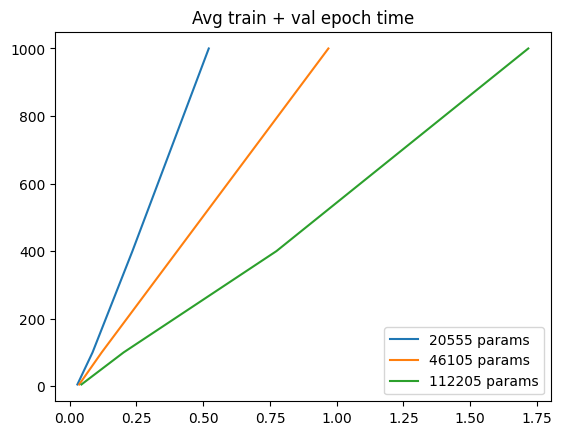

In [118]:
for n_params in df["n_params"].unique():
    plt.plot(
        df[df["n_params"] == n_params]["runtime_mean"], 
        df[df["n_params"] == n_params]["n_qubits"],
        label=f"{n_params} params"
    )
    
plt.title("Avg train + val epoch time")
plt.legend()
plt.show()